In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

# regression
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

# metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

# saver model
import joblib

import ast


Bad key "text.kerning_factor" on line 4 in
C:\Users\anpej\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Importing dataset
main_df = pd.read_csv('../datasets/main_df_clean.csv')
main_df.drop_duplicates(subset=['post_text','time','hashtags'],inplace=True)
main_df = pd.get_dummies(main_df,columns=['post_type'])
main_df['comment_engagement_profile'] = main_df['mean_comments'] / main_df['num_followers']

In [3]:
# Choosing Mega influencers only
df_indluencers = main_df[main_df['influencer_type']=='Midi']
df_indluencers = df_indluencers[df_indluencers['num_likes_post'].between(df_indluencers['num_likes_post'].quantile(0.01),
                                           df_indluencers['num_likes_post'].quantile(0.999))]
df_indluencers.shape

(17747, 45)

In [4]:
# Creating X, y
features = ['num_followers','mean_likes','post_type_carousel','comment_engagement_profile',
           'len_post_text','weekday','hour','polarity_post_txt','subjectivity_post_txt']
X = df_indluencers[features]
y = df_indluencers['num_likes_post']

In [6]:
# Modeling
import xgboost as xgb
model_xgb = xgb.XGBRegressor(learning_rate=0.015, 
                             max_depth=3,
                             min_child_weight=5, 
                             n_estimators=513, 
                             subsample=0.3,
                             booster='gbtree',
                             n_jobs=-1)
model_xgb.fit(X, y)

[17:24:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.015, max_delta_step=0,
             max_depth=3, min_child_weight=5, missing=None, n_estimators=513,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.3, verbosity=1)

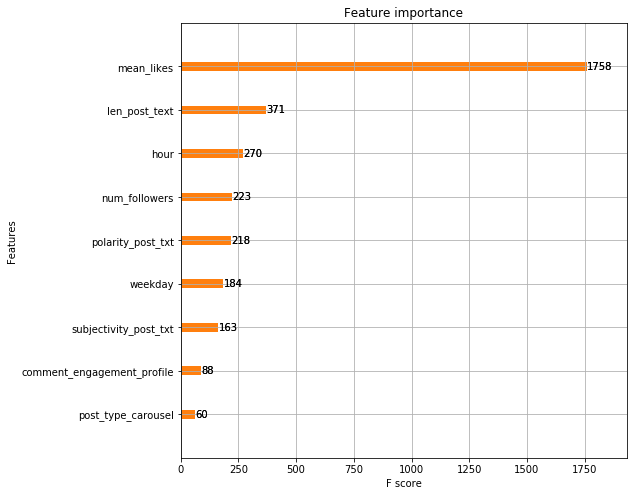

In [7]:
import xgboost as xgb
h = 8
w = 8
fig, ax = plt.subplots(figsize=(h, w))
ax = xgb.plot_importance(model_xgb, importance_type='weight',ax=ax);
xgb.plot_importance(model_xgb, importance_type='weight',ax=ax);

In [8]:
import pickle
file_name = "./saved_models/xgb_likes_midi.pkl"
# save
pickle.dump(model_xgb, open(file_name, "wb"))
# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

[17:24:59] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [8]:
# Function for metrics
def metrics_function(y,predictions,num_features=len(X.columns)):
    '''
    Calculate:
    Mean Absolute Error,
    Residual Sum of Squares,
    Root Mean Squared Error,
    Coefficient of Determination,
    Adjusted R2
    
    Print the values of metrics
    
    Takes:
    y - true target values
    predictions - predicted values
    num_features - number of features
    
    Returns:
    Nothing
    '''
    # Mean Absolute Error
    mae = mean_absolute_error(y,predictions)
    # Residual Sum of Squares
    rss = ((y-predictions)**2).sum()
    # Mean Squared Error
    mse = mean_squared_error(y,predictions)
    # Root Mean Squared Error
    rmse = mse**0.5
    # Coefficient of Determination
    r = r2_score(y,predictions)
    # Adjusted R2
    def r2_adj(y,predictions,num_features):
        r_adj = 1 - (1-r)*(len(y)-1)/(len(y)-num_features-1)
        return r_adj
    r_adj = r2_adj(y,predictions,num_features)
    print(f'Mean Absolute Error: {mae}')
    print(f'Residual Sum of Squares: {rss}')
    print(f'Mean Squared Error: {mse}')
    print(f'Root Mean Squared Error: {rmse}')
    print(f'Coefficient of Determination R2: {r}')
    print(f'Adjusted R2: {r_adj}')

In [10]:
y_pred = xgb_model_loaded.predict(X)
metrics_function(y,y_pred)

Mean Absolute Error: 406.27315211982574
Residual Sum of Squares: 11565847552.0
Mean Squared Error: 651707.2784479588
Root Mean Squared Error: 807.2838896249316
Coefficient of Determination R2: 0.7034765951735737
Adjusted R2: 0.7033261350820454
